In [ ]:
import psycopg2 as pg
import pandas as pd
from queries.db_queries import *
from functions.running_avg import *
from functions.helper_functions import *
from configs import *
import numpy as np
from numpy.linalg import lstsq
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import libraries.libraries

In [2]:
# Retrosheet contains data from teams who have moved/renamed. Therefore, some abbreviations differ from Lahman DB. This dict maps them
renamed_team = {
    'NYN': 'NYM',
    'CHA': 'CHI',
    'SFN': 'SFG',
    'ANA': 'LAA',
    'CHN': 'CHC',
    'TBA': 'TBR',
    'LAN': 'LAD',
    'SDN': 'SDP',
    'WAS': 'WSN',
    'SLN': 'STL',
    'KCA': 'KCR',
    'NYA': 'NYY',
}

In [3]:
game_log_column_headers = [
    "Date",
    "Game Number",
    "Day of Week",
    "Visiting Team",
    "Visiting Team League",
    "Visiting Team Game Number",
    "Home Team",
    "Home Team League",
    "Home Team Game Number",
    "Visiting Team Score",
    "Home Team Score",
    "Length of Game (Outs)",
    "Day/Night Indicator",
    "Park ID",
    "Attendance",
    "Time of Game",
    "Visiting SP",
    "Home SP"
]

Step 1 : Call Funciton to Return all Parks
Step 2 : Loop through each park calculating metrics for each
Step 3 : Devise way to normalize
Step 4 : Compare to Park Factors from Lahman
Step 5 :
Step 6 : Use New metric to predict player performance

In [2]:
team_data = sql_query(curr_teams_query)

## Get Game Logs and Rename Abbr.

In [3]:
log_path_2023 = 'C:/Users/conor/Downloads/gl2023/gl2023.txt'

gamelogs_full = pd.read_csv(log_path_2023, header=None)
gamelogs = pd.concat([gamelogs_full.iloc[:,:13], gamelogs_full.iloc[:,16:19],gamelogs_full.iloc[:,102], gamelogs_full.iloc[:,104]], axis = 1)
gamelogs = gamelogs.set_axis(game_log_column_headers, axis = 1)

#Fix Abbreviations
gamelogs['Visiting Team'] = gamelogs['Visiting Team'].replace(renamed_team)
gamelogs['Home Team'] = gamelogs['Home Team'].replace(renamed_team)

running_avg_df = get_running_avg_df(gamelogs_=gamelogs, timeframe=6)

NameError: name 'game_log_column_headers' is not defined

Score Game Difficulty for Each Pitcher

In [6]:
Difficulty_Score_Home = []
Difficulty_Score_Away = []
for idx, game in gamelogs.iterrows():
    date = game['Date']
    home_chllg_run = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Visiting Team'] == game['Visiting Team'])]['VTRA_S'].values
    home_chllg_overall = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Visiting Team'] == game['Visiting Team'])]['VTA_S'].values
    Difficulty_Score_Home.append(np.average([home_chllg_run,home_chllg_overall], weights= [2,1], axis=0)[0] if len(home_chllg_overall) > 0 else None)

    vis_chllg_run = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Home Team'] == game['Home Team'])]['HTRA_S'].values
    vis_chllg_overall = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Home Team'] == game['Home Team'])]['HTA_S'].values
    Difficulty_Score_Away.append(np.average([vis_chllg_run,vis_chllg_overall], weights= [2,1], axis=0)[0] if len(vis_chllg_overall) > 0 else None)

In [7]:
gamelogs['Home Challenge'] = Difficulty_Score_Home
gamelogs['Visiting Challenge'] = Difficulty_Score_Away

In [8]:
phils = gamelogs[(gamelogs['Visiting Team'] == 'PHI') | (gamelogs['Home Team'] == 'PHI')]
phils = phils.reset_index(drop=True)

phils['Outcome'] = np.where(
    (phils['Home Team'] == 'PHI') & (phils['Home Team Score'] > phils['Visiting Team Score']) | 
    (phils['Visiting Team'] == 'PHI') & (phils['Visiting Team Score'] > phils['Home Team Score']),
    'win', 
    'loss'
)
phils['Opponent'] = np.where( (phils['Home Team'] == 'PHI'), phils['Visiting Team'],phils['Home Team'])
colors = np.where(phils['Outcome'] == 'win', 'green', 'red').tolist()[6:]

phils['Challenge Score'] = np.where(phils['Home Team'] == 'PHI', phils['Home Challenge'], phils['Visiting Challenge'])

C:\Users\conor\AppData\Local\Temp\ipykernel_38688\334038990.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(phils['Challenge Score'][phils.index >= 6].index, phils['Challenge Score'][phils.index >= 6], c=colors, marker='o', edgecolor='black', s=40, cmap='coolwarm')


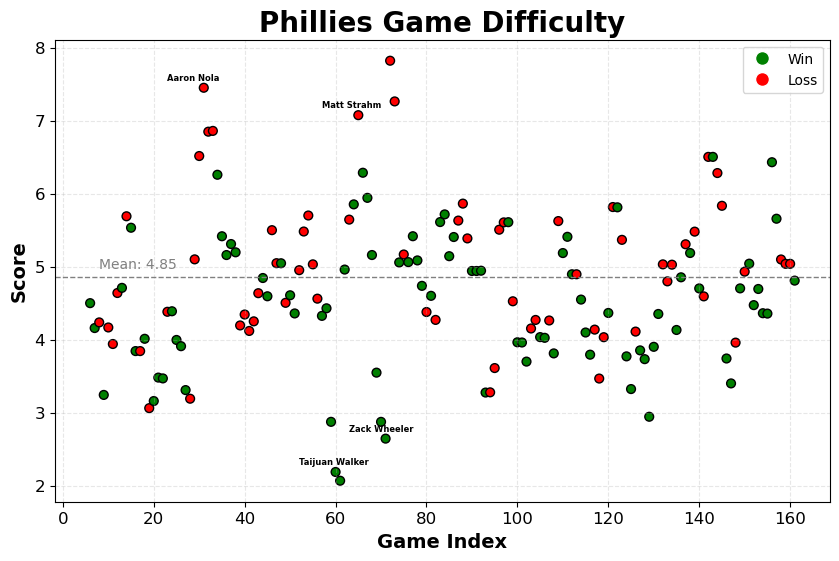

In [9]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(phils['Challenge Score'][phils.index >= 6].index, phils['Challenge Score'][phils.index >= 6], c=colors, marker='o', edgecolor='black', s=40, cmap='coolwarm')
plt.title('Phillies Game Difficulty', fontsize=20, fontweight='bold')
plt.xlabel('Game Index', fontsize=14,fontweight='bold')
plt.ylabel('Score', fontsize=14,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a color legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Win', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Loss', markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

# Adding grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.3)

# Adding mean line for reference
mean = phils['Challenge Score'].mean()
plt.axhline(mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(25, mean + 0.12, f'Mean: {mean:.2f}', color='gray', ha='right')

temp_df = avoid_overlap(phils[((phils['Challenge Score'] > 6.75)|(phils['Challenge Score'] < 2.75) ) & (phils.index >= 6)])
for i, row in temp_df.iterrows():
    if row['Home Team'] == 'PHI':
        plt.text(
            x=i - 8,
            y=row['Challenge Score'] + 0.1,
            s=row['Home SP'],
            ha='left',
            weight='bold',
            fontsize=6
        )
    elif row["Visiting Team"] == 'PHI':
          plt.text(
            x=i - 8,
            y=row['Challenge Score'] + 0.1,
            s=row['Visiting SP'],
            ha='left',
            weight='bold',
            fontsize=6
        ) 

In [10]:
q1 = phils['Challenge Score'].quantile(0.25)
q3 = phils['Challenge Score'].quantile(0.75)
iqr = q3 - q1
tough_games = phils[(phils['Challenge Score'] >= q3 + 1.5*iqr) & (phils.index >= 6)]
easy_games = phils[(phils['Challenge Score'] <= q1 - 1.5*iqr) & (phils.index >= 6)]

In [11]:
score_std = np.std(phils['Challenge Score'][(phils.index >= 6)])
tough_games = phils[(phils['Challenge Score'] >= mean + 2*score_std) & (phils.index >= 6)]
easy_games = phils[(phils['Challenge Score'] <= mean - 2*score_std) & (phils.index >= 6)]
outlier_games = pd.concat([easy_games, tough_games])

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([2.06666667, 2.12435185, 2.18203704, 2.23972222, 2.29740741,
        2.35509259, 2.41277778, 2.47046296, 2.52814815, 2.58583333,
        2.64351852]),
 <BarContainer object of 10 artists>)

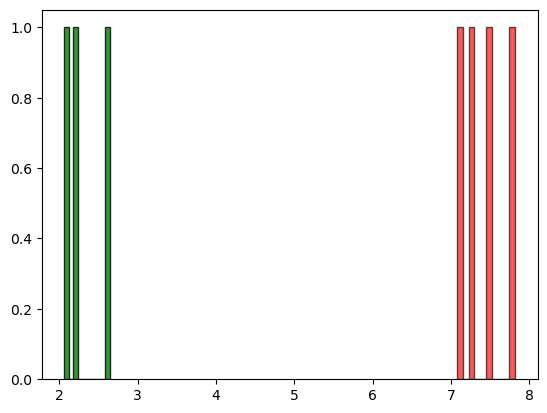

In [12]:
plt.hist(outlier_games['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'loss')], edgecolor='black', alpha = 0.65, color='red')
plt.hist(outlier_games['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'win')], edgecolor='black', alpha = 0.8, color='green')

Text(2.2912896069728106, 17.766, 'Mean Win Score: 4.49')

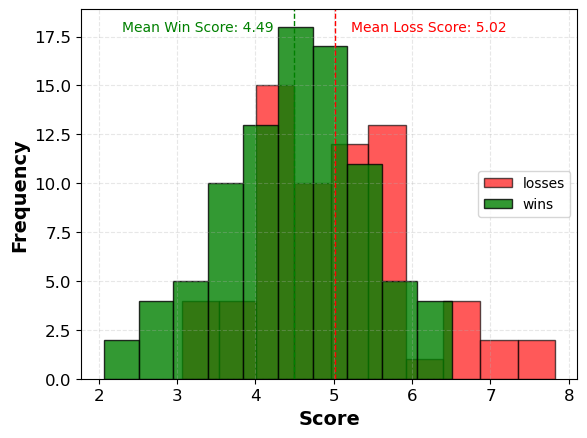

In [13]:
plt.hist(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'loss')], edgecolor='black', alpha = 0.65, color='red', label='losses')
plt.hist(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'win')], edgecolor='black', alpha = 0.8, color='green', label = 'wins')
plt.xlabel('Score', fontsize=14,fontweight='bold')
plt.ylabel('Frequency', fontsize=14,fontweight='bold')
#plt.title('Score Histogram', fontsize=16,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='center right')
loss_mean = np.mean(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'loss')])
win_mean = np.mean(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'win')])

# Add mean line
plt.axvline(loss_mean, color='red', linestyle='dashed', linewidth=1)
plt.text(loss_mean + 0.2, plt.ylim()[1]*0.94, f'Mean Loss Score: {loss_mean:.2f}', color='red')
plt.axvline(win_mean, color='green', linestyle='dashed', linewidth=1)
plt.text(win_mean - 2.2, plt.ylim()[1]*0.94, f'Mean Win Score: {win_mean:.2f}', color='green')

Determine A, b and weights for Weighted Least Squares Regression

In [14]:
gamelogs.reset_index(drop=True, inplace=True)

num_feats = 3
num_teams = len(pd.unique(gamelogs[['Home Team', 'Visiting Team']].values.ravel()))
A = np.zeros((162*30,num_teams*num_feats))
b = np.zeros((162*30,1))

team_data = team_data.sort_values(by ='Team')
team_data.reset_index(drop=True, inplace=True)

In [15]:
idx = 0
weights = []
# Group by 'Home Team' and 'Visiting Team' to calculate the occurrence of each matchup
matchup_counts = gamelogs.groupby(['Home Team', 'Visiting Team']).size().reset_index(name='Count')

# Iterate over the grouped matchups
for (home_team, visiting_team), group in gamelogs.groupby(['Home Team', 'Visiting Team']):
    home_team_idx = team_data.index[team_data['Team'] == home_team]
    visiting_team_idx = team_data.index[team_data['Team'] == visiting_team]
    
    for _, row in group.iterrows():
        # Set offensive team factor
        A[idx, home_team_idx * num_feats] = 1
        A[idx + 1, visiting_team_idx * num_feats] = 1

        # Set defensive team factor
        A[idx, visiting_team_idx * num_feats + 1] = 1
        A[idx + 1, home_team_idx * num_feats + 1] = 1

        # Set park factor (assuming a specific column index for park factors)
        A[idx, home_team_idx * num_feats + 2] = 1  # Adjust this index if park factors are in a different column
        A[idx + 1, home_team_idx * num_feats + 2] = 1

        b[idx] = row['Home Team Score']
        b[idx + 1] = row['Visiting Team Score']
        
        idx += 2
        
        weights.append(len(group))
        weights.append(len(group))

weights = np.array(weights)

Determine Weighted PF

In [16]:
# Add a constant term to the predictors
X = sm.add_constant(A)

# Fit the WLS model
wls_model = sm.WLS(b, X, weights=weights).fit()
beta = wls_model.params 
# Print the summary of the model
#print(wls_model.summary())

In [17]:
# Extract every third coefficient starting from the first coefficient
coefficients = beta[1:]
constant = coefficients[0]

park_factors = []

# Populate the park factor scores
for team in team_data['Team']:
    park_factor = coefficients[team_data.index[team_data['Team'] == team][0] * num_feats + 2]
    park_factors.append(park_factor)

# Create a new DataFrame with teams and their corresponding park factor scores
df_park_factors = pd.DataFrame({
    'Team': team_data['Team'],
    'ParkFactor': park_factors
}).sort_values(by='ParkFactor', ascending= False)

df_park_factors.reset_index(inplace=True, drop=True)
df_park_factors['NormPF'] = min_max_norm(df_park_factors,'ParkFactor')
print('Weighted Park Factors')
print(round(df_park_factors.sort_values(by='ParkFactor', ascending= False).head(),3))


Weighted Park Factors
  Team  ParkFactor  NormPF
0  COL       1.345   1.000
1  TEX       0.724   0.730
2  BOS       0.649   0.697
3  STL       0.510   0.636
4  CHC       0.474   0.621


Read in Baseball Savant's Park Factor Data

In [18]:
SavantPF = pd.read_csv('C:/Users/conor/Downloads/BaseballSavantPF2023.csv')
SavantPF['NormPF_Savant'] = min_max_norm(SavantPF,'Park Factor')

In [19]:
JoinPFs = pd.merge(df_park_factors, SavantPF, on='Team')
JoinPFs = JoinPFs.drop(columns=['Rank'])
JoinPFs['Diff'] = (abs(JoinPFs['NormPF'] - JoinPFs['NormPF_Savant'])*100).round(3)

In [ ]:
JoinPFs.sort_values(by='ParkFactor', ascending=False)

Lets Adjust ERA for Difficulty and PF Score

In [21]:
phils_pitchers = sql_query(Phils_SP_query)

In [64]:
Names = []
avg_diffs = []
avg_norm_pf = []

for pitcher in phils_pitchers['Full Name']:
    pf = []
    games_started = phils[(phils['Home SP'] == pitcher) | (phils['Visiting SP'] == pitcher)]
    for idx, game in games_started.iterrows():
        park_factor = df_park_factors['NormPF'][df_park_factors['Team'] == game['Home Team']].values
        if len(park_factor) > 0:
            pf.append(park_factor)
    avg_diff = np.mean(games_started['Challenge Score'])
    avg_norm_pf.append(round(np.mean(pf),2))
    Names.append(pitcher)
    avg_diffs.append(round(avg_diff,2))

Pitchers_2023 = pd.DataFrame({
'Name': Names,
'Avg Game Difficulty Score': avg_diffs,
'ERA': phils_pitchers['era'],
'PF_Norm': avg_norm_pf
}).sort_values(by='Avg Game Difficulty Score', ascending= False)
    

In [65]:
Pitchers_2023

,Name,Avg Game Difficulty Score,ERA,PF_Norm
0,Aaron Nola,5.03,4.46,0.44
2,Ranger Suarez,4.90,4.18,0.47
4,Zack Wheeler,4.88,3.61,0.41
3,Taijuan Walker,4.64,4.38,0.42
1,Cristopher Sanchez,4.60,3.44,0.43
